### Predict and evaluate
- **predict**: create a model, load the trained weights and predict
- **evaluate**: compare the predictions to the ground truth, compute metrics (precision, recall, PR_AUC) and plot curves

In [3]:
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt
from os.path import exists
from hierarchical_model import HierarchicalModel 

### Select the training configuration

In [4]:
# ================== HYPER-PARAMETERS ==================

from configs import configs
config = configs[0]

old_stdout = sys.stdout
if not exists(config['results_folder'] + '/log_eval.txt'):
    log_file = open(config['results_folder'] + '/log_eval.txt', 'w')
else:
    raise FileExistsError
sys.stdout = log_file

In [5]:
test, _ = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                      batch_size=config['batch_size'],
                      image_dimension=config['image_dimension'])
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)
label_frequencies = y_true_test.sum(axis=0) / y_true_test.sum()

In [6]:
THRESHOLD_MOVE = True

Load test set

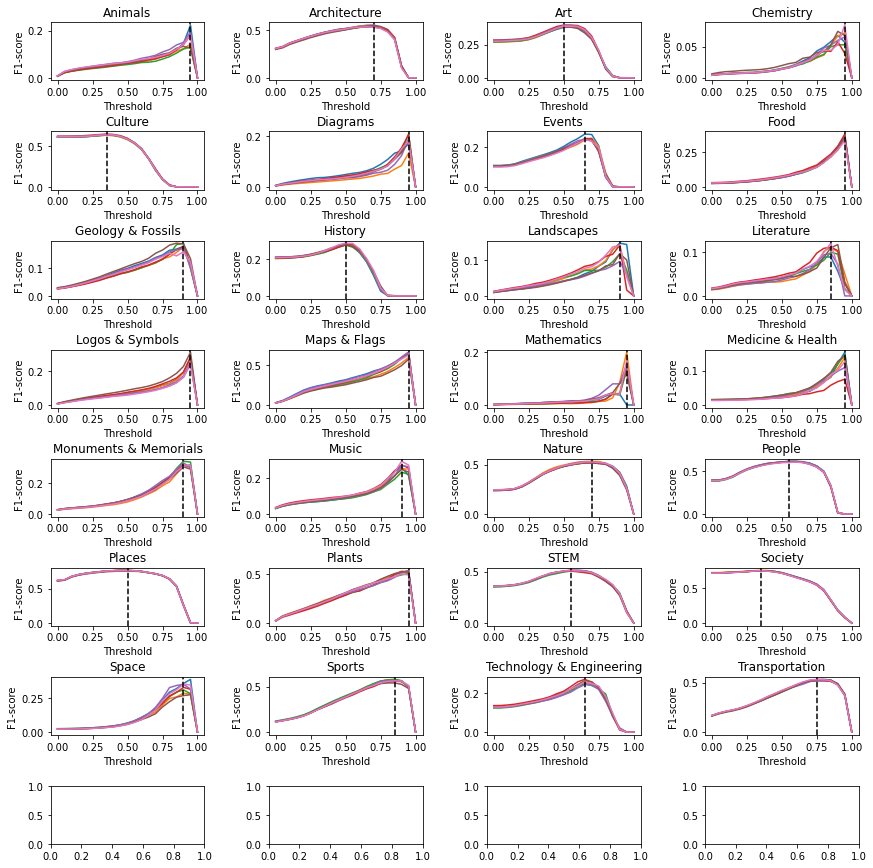

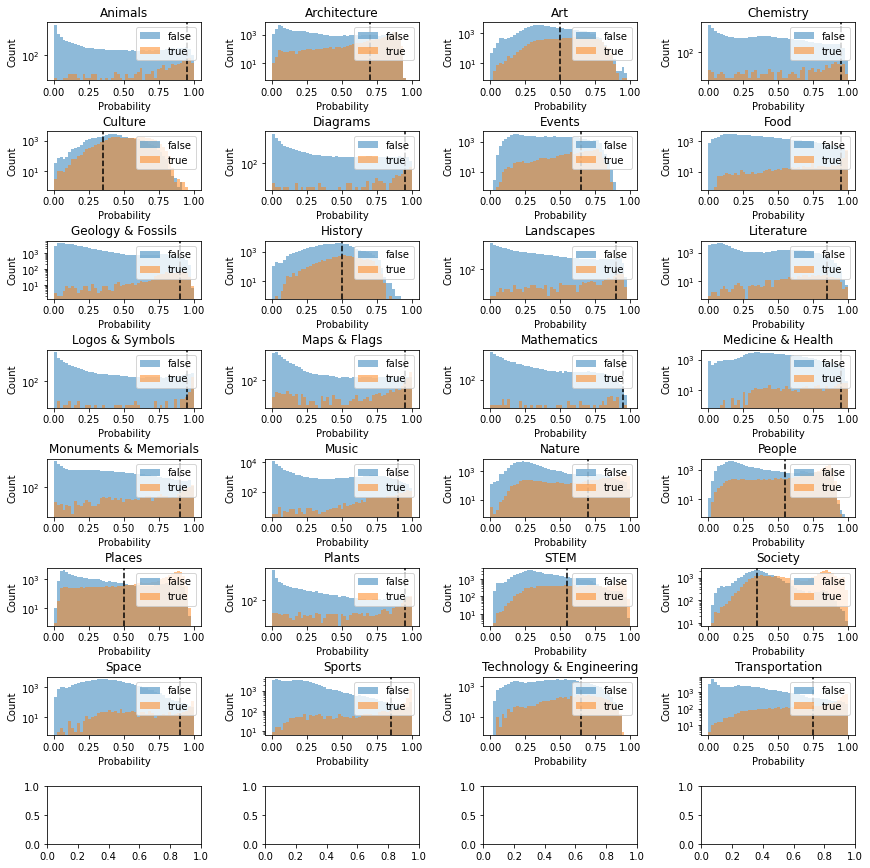

In [7]:
# Create model
if config['hierarchical']:
    model = HierarchicalModel(nr_labels=len(test.class_indices), image_dimension=config['image_dimension'])
else:
    print('creating model')
    model = hf.create_model(n_labels=len(test.class_indices), image_dimension=config['image_dimension'], number_trainable_layers=config['number_trainable_layers'])
latest = tf.train.latest_checkpoint(config['results_folder'])
print(latest)
model.load_weights(latest)

# Predict on test set
print('Predicting on test set:\n')
probs_test = model.predict(test, verbose=2)
print('finished predicting')
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)
y_pred_test_05 = 1 * (probs_test > 0.5)

if THRESHOLD_MOVE:
    val_threshold, _ = hf.get_flow(df_file=config['data_folder'] + '/thresh_df.json.bz2',
                                   batch_size=config['batch_size'],
                                   image_dimension=config['image_dimension'])
    # Use the second validation set to the thresholds that optimize f1-score
    print('Predicting on validation set:\n')
    probs_val = model.predict(val_threshold, verbose=2)
    y_true_val = hf.get_y_true(shape=probs_val.shape, classes=val_threshold.classes)

    optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, 
                                            probs=probs_val, 
                                            thresholds=np.linspace(start=0, stop=1, num=21), 
                                            labels=list(val_threshold.class_indices.keys()), 
                                            N=7,
                                            image_path=config['results_folder'])
    y_pred_test_per_class_threshold = 1 * (probs_test > optim_thresholds)

### Distribution of predictions

In [8]:
pctgs = [round(100 * pctg, 4) for pctg in y_pred_test_05.sum(axis=0) / y_pred_test_05.sum().sum()]
print('\n---------- DISTRIBUTION OF PREDICTIONS ----------')
print(dict(zip(list(test.class_indices.keys()), pctgs)))
if THRESHOLD_MOVE:
    pctgs = [round(100 * pctg, 4) for pctg in y_pred_test_per_class_threshold.sum(axis=0) / y_pred_test_per_class_threshold.sum().sum()]
    print('\n---------- DISTRIBUTION OF PREDICTIONS (individual thresholds) ----------')
    print(dict(zip(list(test.class_indices.keys()), pctgs)))

In [9]:
def plot_f1_scores_side_by_side(f1_scores_05, f1_scores_thresh, image_path):
    plt.figure(figsize=(12, 6))
    x_axis = np.arange(len(f1_scores_05.keys()))
    plt.bar(x_axis-0.1, f1_scores_05.values, width=0.2, label='Threshold 0.5')
    plt.bar(x_axis+0.1, f1_scores_thresh.values, width=0.2, label='Per-class threshold')
    plt.legend(fontsize=12)
    _ = plt.xticks(x_axis, f1_scores_05.keys(), rotation=70, rotation_mode='anchor', ha="right", fontsize=14)
    # plt.title('F1-scores comparison')
    plt.ylabel('F1-score')
    plt.xlabel('Label')
    try:
        plt.savefig(image_path + '/f1-scores-threshold-moving-or-05.png', bbox_inches='tight')
    except:
        print('Could not save image...')

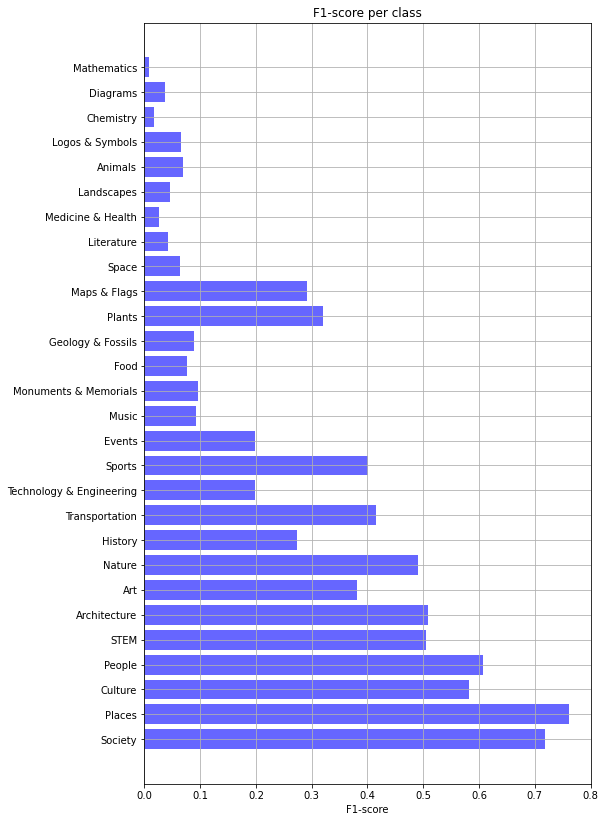

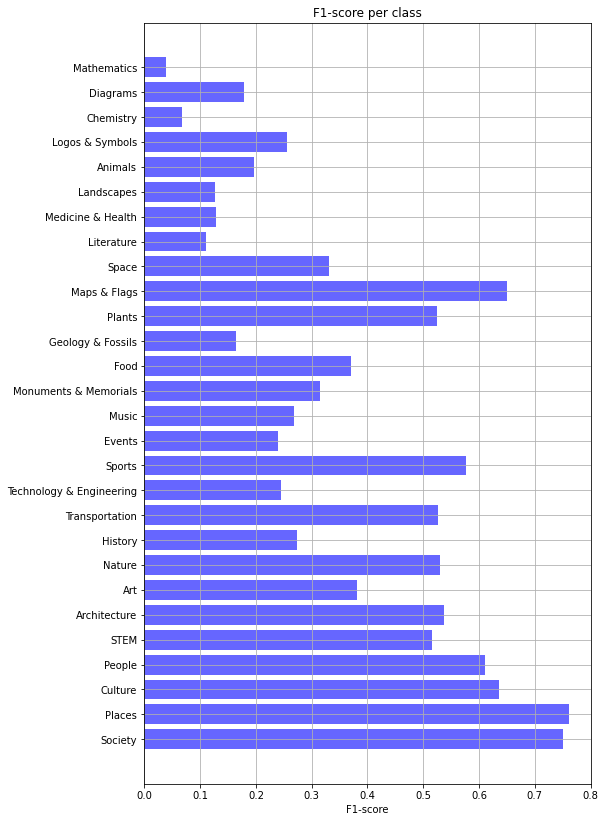

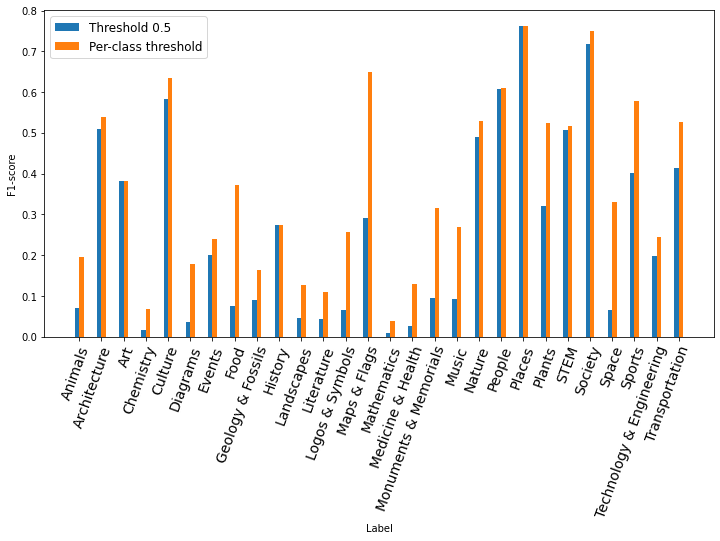

In [10]:
# ================== GET METRICS ======================
print('METRICS FOR THRESHOLD 0.5')
f1_scores_05 = hf.get_metrics(y_true_test, y_pred_test_05, label_names=list(test.class_indices.keys()), image_path=config['results_folder'] + '/f1_scores.png')

if THRESHOLD_MOVE:
    print('METRICS WHEN HAVING PER-CLASS THRESHOLDS')
    f1_scores_thresh = hf.get_metrics(y_true_test, y_pred_test_per_class_threshold, label_names=list(test.class_indices.keys()), image_path=config['results_folder'] + '/f1_scores.png')
    plot_f1_scores_side_by_side(f1_scores_05, f1_scores_thresh, config['results_folder'])

### Precision recall curve

<Figure size 1080x720 with 0 Axes>

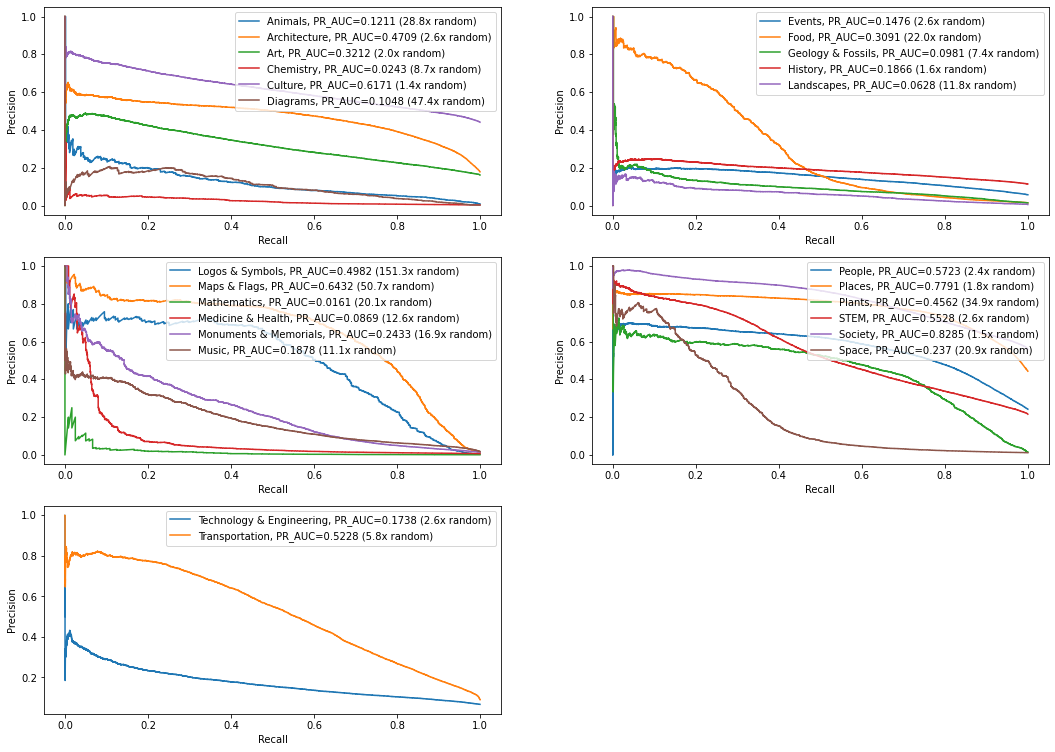

<Figure size 432x288 with 0 Axes>

In [14]:
from sklearn.metrics import precision_recall_curve, auc

# precision recall curve
def plot_pr_curve(y_true, probs, label_names):
    plt.figure(figsize=(15,10))
    precision = dict()
    recall = dict()
    pr_auc = dict()
    random_auc = dict()
    n_images = y_true.shape[0]
    n_labels = len(label_names)

    for i in range(n_labels):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], probs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        random_auc[i] = y_true[:, i].sum() / n_images

    plt.figure(figsize=(18, 13))
    
    plt.subplot(3, 2, 1)
    for i in range(0, 6):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 2)
    for i in range(6, 11):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 3)
    for i in range(12, 18):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 4)
    for i in range(19, 25):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 5)
    for i in range(26, 28):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')
    plt.show()
    # hf.save_img(config['results_folder'] + '/pr_curve.png')
    
    return precision, recall, pr_auc, random_auc

precision, recall, pr_auc, random_auc = plot_pr_curve(y_true_test, probs_test, list(test.class_indices.keys()))


In [15]:
metrics_dict = dict()
metrics_dict['label_name'] = list(test.class_indices.keys())
metrics_dict['pr_auc'] = list(pr_auc.values())
metrics_dict['random_auc'] = list(random_auc.values())
metrics_dict['frequency'] = label_frequencies
metrics_df = pd.DataFrame(metrics_dict)
metrics_df['better_than_random'] = round(metrics_df['pr_auc'] / metrics_df['random_auc'], 3)
macro_pr_auc = metrics_df['pr_auc'].sum() / len(metrics_df)
print(f'\n\n-------------------------- PR AUC metrics table -----------------------')
print(f'Macro PR_AUC is: {macro_pr_auc}')
print(metrics_df)
metrics_df.head(31)

,label_name,pr_auc,random_auc,frequency,better_than_random
0,Animals,0.121132,0.004200,0.001450,28.841
1,Architecture,0.470945,0.178133,0.061489,2.644
2,Art,0.321228,0.161280,0.055672,1.992
3,Chemistry,0.024332,0.002800,0.000967,8.690
4,Culture,0.617074,0.440853,0.152177,1.400
5,Diagrams,0.104806,0.002213,0.000764,47.352
6,Events,0.147573,0.056653,0.019556,2.605
7,Food,0.309135,0.014053,0.004851,21.997
8,Geology & Fossils,0.098087,0.013260,0.004577,7.397
9,History,0.186614,0.113540,0.039192,1.644


In [9]:
print('\n\n----------------------Sorted by the best PR_AUC-------------------')
print(metrics_df.sort_values('pr_auc', ascending=False))
metrics_df.sort_values('pr_auc', ascending=False)

,label_name,pr_auc,random_auc,better_than_random
26,Society,0.749796,0.53782,1.394
22,Places,0.687566,0.38878,1.769
20,People,0.492898,0.20262,2.433
15,Maps & Flags,0.490895,0.01468,33.440
6,Culture,0.463371,0.34052,1.361
25,STEM,0.445204,0.23260,1.914
19,Nature,0.438558,0.14398,3.046
28,Sports,0.393023,0.06060,6.486
23,Plants,0.357514,0.01124,31.807
4,Biology,0.257021,0.00638,40.285


In [8]:
sys.stdout = old_stdout

log_file.close()